In [2]:
%reload_ext autoreload
%autoreload 2

### Define the Stieltjes transform $t_r(z)$ as in Peixoto 2013, Spectra of random modular graphs and the symbols

In [38]:
import sys
sys.path.append('..')
import numpy as np
from numpy.random import random as rand

import networkqit as nq
import networkx as nx

from networkqit import graph_laplacian as GL
from networkqit import normalized_graph_laplacian as NGL

import scipy.optimize
import scipy.linalg

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sympy as sp
import sympyprinting as spp
from sympy import init_printing

import mpmath as mp
import networkx as nx
init_printing()

## Define utility functions to generate networks

In [4]:
def planted_partition_graph(n,b,pin,pout):
    nb = int(n/b)
    A = (np.random.random((n,n)) < pout).astype(float)
    for i in range(0,b):
        T = np.triu((np.random.random((nb,nb))<pin).astype(float))
        T = T+T.T
        A[i*nb:(i+1)*nb,i*nb:(i+1)*nb] = T
        
    np.fill_diagonal(A,0)
    A = np.triu(A)
    A = A+A.T
    return A

def hierarchical_random_graph(sigma2rs,nr):
    N = np.sum(nr)
    A = np.zeros([N,N])
    b = len(sigma2rs)
    idx = np.cumsum([0]+nr)
    for i in range(0,b):
        ri  = np.array(range(idx[i],idx[i+1]+1))
        for j in range(0,b):
            rj  = np.array(range(idx[j],idx[j+1]+1))
            A[ri.min():ri.max(),rj.min():rj.max()] = np.random.random([len(ri)-1,len(rj)-1]) < sigma2rs[i,j]
    A = np.triu(A,1)
    A += A.T
    return A

### Generate an example network

In [50]:
sigma2 = np.array([[0.8,0.2],[0.2,0.2]])
M = np.kron(sigma2,sigma2)#,np.array([[0.8,0.1],[0.5,1]])
#M = np.array([[0.5]])
#M = ( M+M.T) / 2
print(M.shape)
#nr = [20,30,40,50]
nr = [1000,500]*2

reps = 5
a = np.array([scipy.linalg.eigvalsh(hierarchical_random_graph(M, nr)) for i in range(0,reps)]).flatten()
l = np.array([scipy.linalg.eigvalsh(GL(hierarchical_random_graph(M, nr))) for i in range(0,reps)]).flatten()
nl = np.array([scipy.linalg.eigvalsh(NGL(hierarchical_random_graph(M, nr))) for i in range(0,reps)]).flatten()

(4, 4)


## Plot them separately, together with their spectra

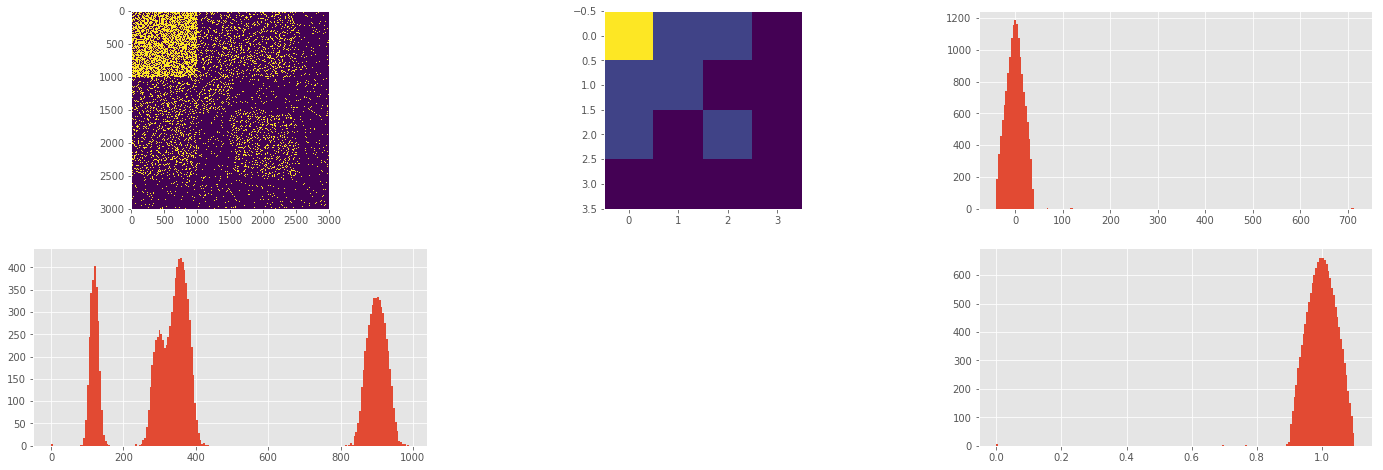

In [51]:
plt.figure(figsize=(24,8))
plt.subplot(2,3,1)
plt.imshow(hierarchical_random_graph(M, nr))
plt.grid(False)

plt.subplot(2,3,2)
plt.imshow(M)
plt.grid(False)

plt.subplot(2,3,3)
plt.hist(a,200)

plt.subplot(2,3,4)
plt.hist(l,200)

plt.subplot(2,3,6)
plt.hist(nl,200)
plt.show()

## Define the functions to compute the spectral density

In [81]:
def compute_tr(z, t0, sigma2, nr, pr_, tol=1E-16, maxsteps=100):
    b = sigma2.shape[0]
    if len(nr) != b:
        raise 'sigma2rs and nr must have same dimensions'
    
    # Define the variables $t_r(z)$ which are the Stieltjes transforms to look for
    tr_ = [sp.symbols('t'+str(i),complex=True) for i in range(0,b)]
    Eq2 = []
    for r in range(0,b):
        c_ = list(pr_[r].free_symbols)[0]
        sum_sigma2rs_ns_ts = np.array([sigma2[r,s]*nr[s]*tr_[s] for s in range(0,b)]).sum()
        #print(sum_sigma2rs_ns_ts)
        fund_eq = tr_[r] -  sp.summation( pr_[r]/(z - c_ - sum_sigma2rs_ns_ts ) , (c_,0,sp.oo))
        # Simplify the fundamental Equation
        fund_eq = sp.simplify(fund_eq)
        # Generate its lambdified expression, for evaluation with mpmath
        F = sp.lambdify(tr_,fund_eq.replace('exp_polar','exp'), modules='mpmath')
        # Append in the list of equations to be solved simulateously
        Eq2.append(F)
    # Now look for the solutions with respect to [t0,t1,...,tb] at this given z
    t = mp.findroot(Eq2, x0=t0, solver='muller', tol=tol, maxsteps=maxsteps)    
    return [t[i] for i in range(0,b)]

def compute_detached_tr(M, z0, t0, nr, pr_, eps=1E-12,maxsteps=100):
    b = M.shape[0]
    if len(nr) != b:
        raise 'Incompatible size of matrix M and total number of blocks'
    IB = sp.eye(b)
    NB = sp.diag(*nr)
    def TzB(z):
        val = sp.diag(*compute_tr(z+eps*1j, t0, M, nr, pr_))
        return val
    
    def eq4(z): # Equation 4 of Peixoto paper
        det = sp.simplify((IB - TzB(z)*M*NB).det())
        return mp.mpc(det)
    
    def trsum(z):
        tr = compute_tr(z+eps*1j, t0, M, nr, [sp.KroneckerDelta(sp.Symbol('c',integer=True),0)] * b)
        return np.sum([t.imag for t in tr])
    z_detached =  mp.findroot(lambda z : eq4(z), x0= mp.mpc(z0), solver='muller', verbose=False, maxsteps=maxsteps)
    return z_detached

def compute_rho(allz, M, nr, matrix, eps=1E-12, maxsteps=150, include_isolated=False, t0=None):
    import time
    from etaprogress.progress import ProgressBar

    bar = ProgressBar(len(allz), max_width=40)
    
    allzlist = allz.tolist()
    rho = np.zeros_like(allz) # initialize rho as zeros
    rholist = rho.tolist()
    b = M.shape[0]
    if t0 is None:
        t0 = [0 + 0.001j] * b # use a default initial value for the stieltjes transform tr
    pr = None
    c = sp.Symbol('c',integer=True) # symbolic variable to sum over in the fundamental equation
    N = np.sum(nr) # total number of nodes
    nrns = np.array([ [(nr[r]*(nr[s]-1)) if r==s else nr[r]*nr[s] for s in range(0,b)] for r in range(0,b)])
    ers = np.multiply(M,nrns) # elementwise multiplication
    dr = np.diagonal(np.diag(nr)*M)
    # Define the pr variable depending on the matrix to investigate
    if matrix is 'laplacian':
        pr = [sp.exp(-dr[r]) * (dr[r]**c) / sp.gamma(c + 1) for r in range(0,b)]
    elif matrix is 'adjacency':
        pr = [sp.KroneckerDelta(c,0) for i in range(0,b)]
    elif matrix is 'norm_laplacian':
        pr = [sp.KroneckerDelta(c,1) for i in range(0,b)]

    print('Continuos band')
    for i,z in enumerate(allz):
        bar.numerator = i+1
        #print('\r',bar,end='')
        t = compute_tr(z + eps*1j, t0, M, nr, pr)
        t0 = t
        rho[i] = -(1.0 / (N*np.pi)) * np.sum([nr[r]*(t[r].imag) for r in range(0,b)])
        print('\r%s Percent done=%.1f %%\tz=%.2f\trho(z)=%g\t%s' % (bar,float(i+1)/len(allz)*100,z,rho[i],t), end='')

    # Then look for the detached eigenvalues by looking for the z such that it solves Eq.4=0
    # where rho is 0 look for separate eigenvalues
    if include_isolated:
        zi,ti = None,None
        print('\nDiscrete band')
        zi = mp.mpc(np.min(allz))
        for z in allz:
            if mp.re(zi) <= z:
                lastzi = zi
                zi = compute_detached_tr(M, z, [1E-5j] * b, nr, pr, maxsteps=maxsteps)
                if np.abs(mp.re(lastzi)-mp.re(zi)) > eps:
                    allzlist.append(mp.re(zi))
                    rholist.append(0.05) # to avoid considering same solution twice
                    print('found isolated eigenvalue zi=%g' % (zi.real))

        return allzlist, rholist
    else:
        return allz, rho

## Compute adjacency spectrum

In [82]:
allz, rho = compute_rho(np.linspace(-70,70,10), M, nr, 'adjacency', eps=1E-6, maxsteps=300, include_isolated=False)

Continuos band
100% (10/10) [#############] eta 00:01 - Percent done=100.0 %	z=70.00	rho(z)=1.04716e-10	[mpc(real='0.018466393001946736', imag='-4.6664245510381203e-10'), mpc(real='0.01540997572145725', imag='-2.638994112003051e-10'), mpc(real='0.015639443456397915', imag='-2.7604670415520949e-10'), mpc(real='0.014698620669330577', imag='-2.2457846044962386e-10')]

# Plot adjacency spectrum

In [ ]:
plt.figure(figsize=(12,8))
x = plt.hist(a,bins=500, density=True)
norm_factor = 1
plt.plot(allz/norm_factor,rho*norm_factor)
plt.show()

## Compute Laplacian spectrum

In [84]:
allz, rho = compute_rho(np.linspace(0,300,50), M, nr, 'laplacian', eps=1E-9, maxsteps=200, include_isolated=False,t0=[(0+1j)*1E-6]*len(nr))

Continuos band
100% (50/50) [#############] eta 00:01 | Percent done=100.0 %	z=300.00	rho(z)=8.42456e-15	[mpc(real='-0.0029603182427040274', imag='-8.9565396052528047e-15'), mpc(real='0.0045582884950080948', imag='-2.0927693634461827e-14'), mpc(real='0.0072478105072919158', imag='-5.3561138955012897e-14'), mpc(real='0.0035766147325756092', imag='-1.2836110911249729e-14')]

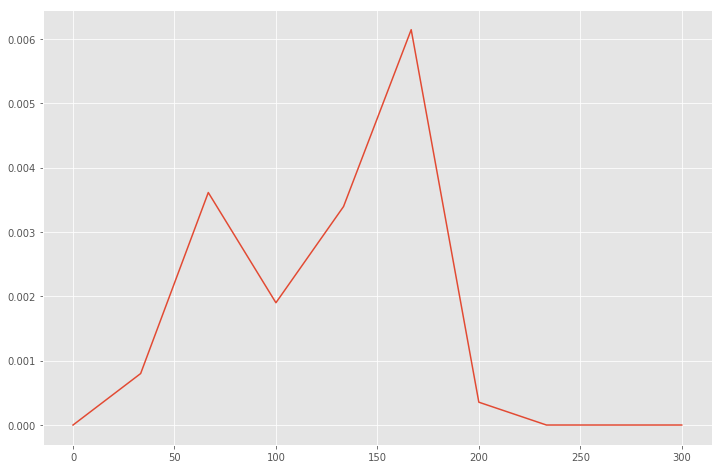

In [71]:
plt.figure(figsize=(12,8))
#x = plt.hist(l,bins=500, density=True)
norm_factor = 1
plt.plot(allz/norm_factor,rho*norm_factor)
plt.show()

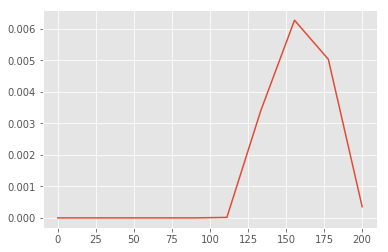

In [31]:
plt.plot(allz,rho)